In [10]:
%load_ext autoreload
%autoreload

# !nrnivmodl mechanisms
import bluepyopt as bpopt
import bluepyopt.ephys as ephys

import pprint
pp = pprint.PrettyPrinter(indent=2)

import matplotlib.pyplot as plt
%matplotlib notebook
import MEAutility as mu

import json
import numpy
import time
import numpy as np
import LFPy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define extracellular electrodes

In [11]:
mea_positions = np.zeros((5, 3))
mea_positions[:, 2] = 20
mea_positions[:, 1] = np.linspace(0, 900, 5)
probe = mu.return_mea(info={'pos': mea_positions, 'center': False, 'plane': 'xy'})
electrode = LFPy.RecExtElectrode(probe=probe, method='linesource')

## Setup protocols, fitness, and evaluator

In [12]:
import l5pc_model
import l5pc_evaluator

feature_set = "soma" # 'soma'/'bap'

morphology = ephys.morphologies.NrnFileMorphology('morphology/C060114A7.asc', do_replace_axon=True)
param_configs = json.load(open('config/parameters.json'))
parameters = l5pc_model.define_parameters()
mechanisms = l5pc_model.define_mechanisms()

l5pc_cell = ephys.models.LFPyCellModel('l5pc', 
                                       v_init=-65., 
                                       morph=morphology, 
                                       mechs=mechanisms, 
                                       params=parameters)

param_names = [param.name for param in l5pc_cell.params.values() if not param.frozen]      

if feature_set == "extra":
    fitness_protocols = l5pc_evaluator.define_protocols(electrode) 
else:
    fitness_protocols = l5pc_evaluator.define_protocols() 

fitness_calculator = l5pc_evaluator.define_fitness_calculator(fitness_protocols, feature_set=feature_set, 
                                                              probe=probe)

if feature_set == "extra":
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True)
else:
    sim = ephys.simulators.LFPySimulator(LFPyCellModel=l5pc_cell, cvode_active=True, electrode=electrode)

evaluator = ephys.evaluators.CellEvaluator(                                          
                cell_model=l5pc_cell,                                                       
                param_names=param_names,                                                    
                fitness_protocols=fitness_protocols,                                        
                fitness_calculator=fitness_calculator,                                      
                sim=sim) 

In [13]:
for objective in fitness_calculator.objectives:
    print(objective.features[0].name)

Step3.soma.AP_height
Step3.soma.AHP_slow_time
Step3.soma.ISI_CV
Step3.soma.doublet_ISI
Step3.soma.adaptation_index2
Step3.soma.mean_frequency
Step3.soma.AHP_depth_abs_slow
Step3.soma.AP_width
Step3.soma.time_to_first_spike
Step3.soma.AHP_depth_abs
Step2.soma.AP_height
Step2.soma.AHP_slow_time
Step2.soma.ISI_CV
Step2.soma.doublet_ISI
Step2.soma.adaptation_index2
Step2.soma.mean_frequency
Step2.soma.AHP_depth_abs_slow
Step2.soma.AP_width
Step2.soma.time_to_first_spike
Step2.soma.AHP_depth_abs
Step1.soma.AP_height
Step1.soma.AHP_slow_time
Step1.soma.ISI_CV
Step1.soma.doublet_ISI
Step1.soma.adaptation_index2
Step1.soma.mean_frequency
Step1.soma.AHP_depth_abs_slow
Step1.soma.AP_width
Step1.soma.time_to_first_spike
Step1.soma.AHP_depth_abs


In [14]:
release_params = {
    'gNaTs2_tbar_NaTs2_t.apical': 0.026145,
    'gSKv3_1bar_SKv3_1.apical': 0.004226,
    'gImbar_Im.apical': 0.000143,
    'gNaTa_tbar_NaTa_t.axonal': 3.137968,
    'gK_Tstbar_K_Tst.axonal': 0.089259,
    'gamma_CaDynamics_E2.axonal': 0.002910,
    'gNap_Et2bar_Nap_Et2.axonal': 0.006827,
    'gSK_E2bar_SK_E2.axonal': 0.007104,
    'gCa_HVAbar_Ca_HVA.axonal': 0.000990,
    'gK_Pstbar_K_Pst.axonal': 0.973538,
    'gSKv3_1bar_SKv3_1.axonal': 1.021945,
    'decay_CaDynamics_E2.axonal': 287.198731,
    'gCa_LVAstbar_Ca_LVAst.axonal': 0.008752,
    'gamma_CaDynamics_E2.somatic': 0.000609,
    'gSKv3_1bar_SKv3_1.somatic': 0.303472,
    'gSK_E2bar_SK_E2.somatic': 0.008407,
    'gCa_HVAbar_Ca_HVA.somatic': 0.000994,
    'gNaTs2_tbar_NaTs2_t.somatic': 0.983955,
    'decay_CaDynamics_E2.somatic': 210.485284,
    'gCa_LVAstbar_Ca_LVAst.somatic': 0.000333
}

In [15]:
t_start = time.time()
LFPy_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), 
                                         param_values=release_params)
t_end = time.time()
print(t_end-t_start)

54.790006160736084


In [16]:
def plot_responses(responses):
    fig, axes = plt.subplots(len(responses), figsize=(10,10))
    for index, (resp_name, response) in enumerate(sorted(responses.items())):
        axes[index].plot(response['time'], response['voltage'], label=resp_name)
        axes[index].set_title(resp_name)
    fig.tight_layout()
    fig.show()

<IPython.core.display.Javascript object>


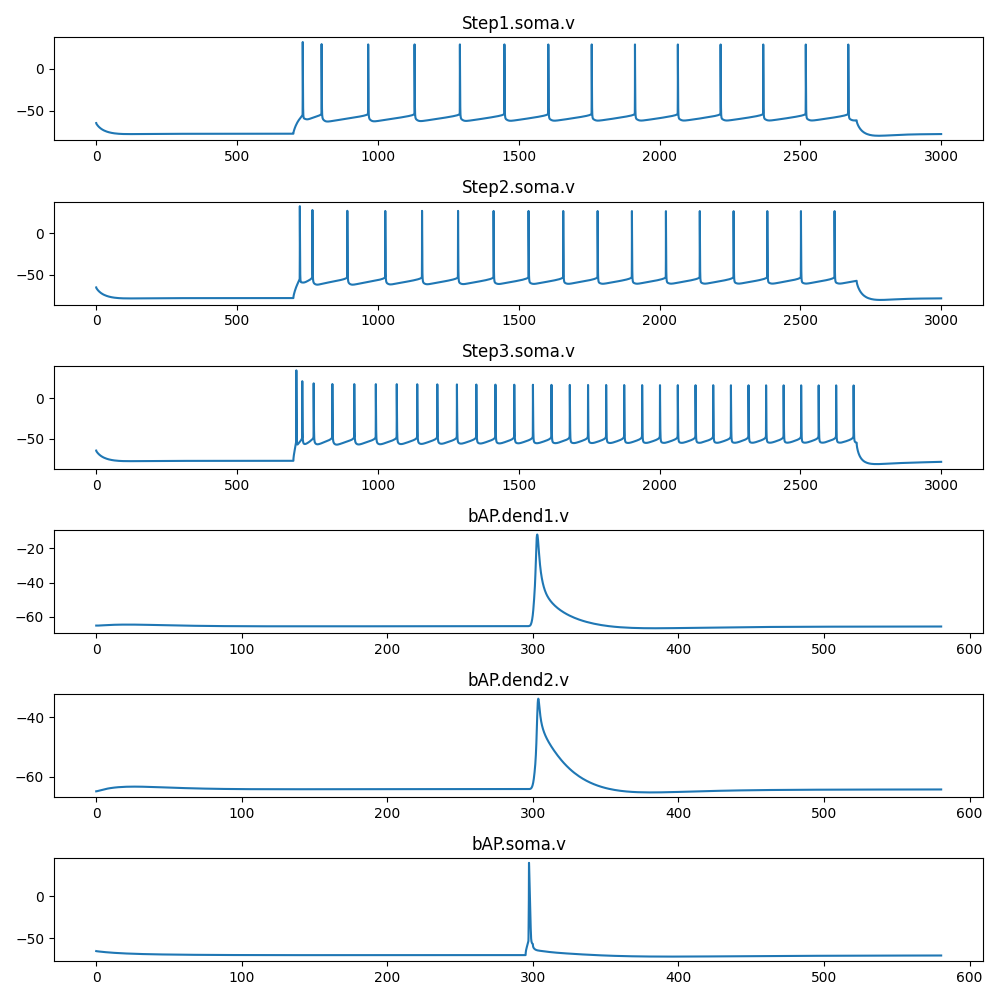

In [17]:
plot_responses(LFPy_responses)

## Optimization

In [18]:
offspring_size = 2
max_ngen = 2

In [19]:
opt = bpopt.optimisations.DEAPOptimisation(                                     
    evaluator=evaluator,                                                            
    offspring_size=offspring_size) 
final_pop, halloffame, log, hist = opt.run(max_ngen=max_ngen, cp_filename='checkpoints/checkpoint_soma.pkl')

In [20]:
best_params = evaluator.param_dict(halloffame[0])
print(pp.pprint(best_params))
best_responses = evaluator.run_protocols(protocols=fitness_protocols.values(), param_values=best_params)

{ 'decay_CaDynamics_E2.axonal': 234.40541659093483,
  'decay_CaDynamics_E2.somatic': 202.18814057682334,
  'gCa_HVAbar_Ca_HVA.axonal': 0.0004958122413818507,
  'gCa_HVAbar_Ca_HVA.somatic': 0.0008375779756625729,
  'gCa_LVAstbar_Ca_LVAst.axonal': 0.002330844502575726,
  'gCa_LVAstbar_Ca_LVAst.somatic': 0.005564543226524335,
  'gImbar_Im.apical': 0.0009391491627785106,
  'gK_Pstbar_K_Pst.axonal': 0.4221165755827173,
  'gK_Tstbar_K_Tst.axonal': 0.0029040787574867947,
  'gNaTa_tbar_NaTa_t.axonal': 1.5248169507528497,
  'gNaTs2_tbar_NaTs2_t.apical': 0.001017834439738432,
  'gNaTs2_tbar_NaTs2_t.somatic': 0.4596034657377336,
  'gNap_Et2bar_Nap_Et2.axonal': 0.8663975885224535,
  'gSK_E2bar_SK_E2.axonal': 0.022169166627303505,
  'gSK_E2bar_SK_E2.somatic': 0.0021489705265908877,
  'gSKv3_1bar_SKv3_1.apical': 0.021656498911739864,
  'gSKv3_1bar_SKv3_1.axonal': 0.8757751873011441,
  'gSKv3_1bar_SKv3_1.somatic': 0.28978161459048557,
  'gamma_CaDynamics_E2.axonal': 0.011927893806278723,
  'gamma_CaD

<IPython.core.display.Javascript object>


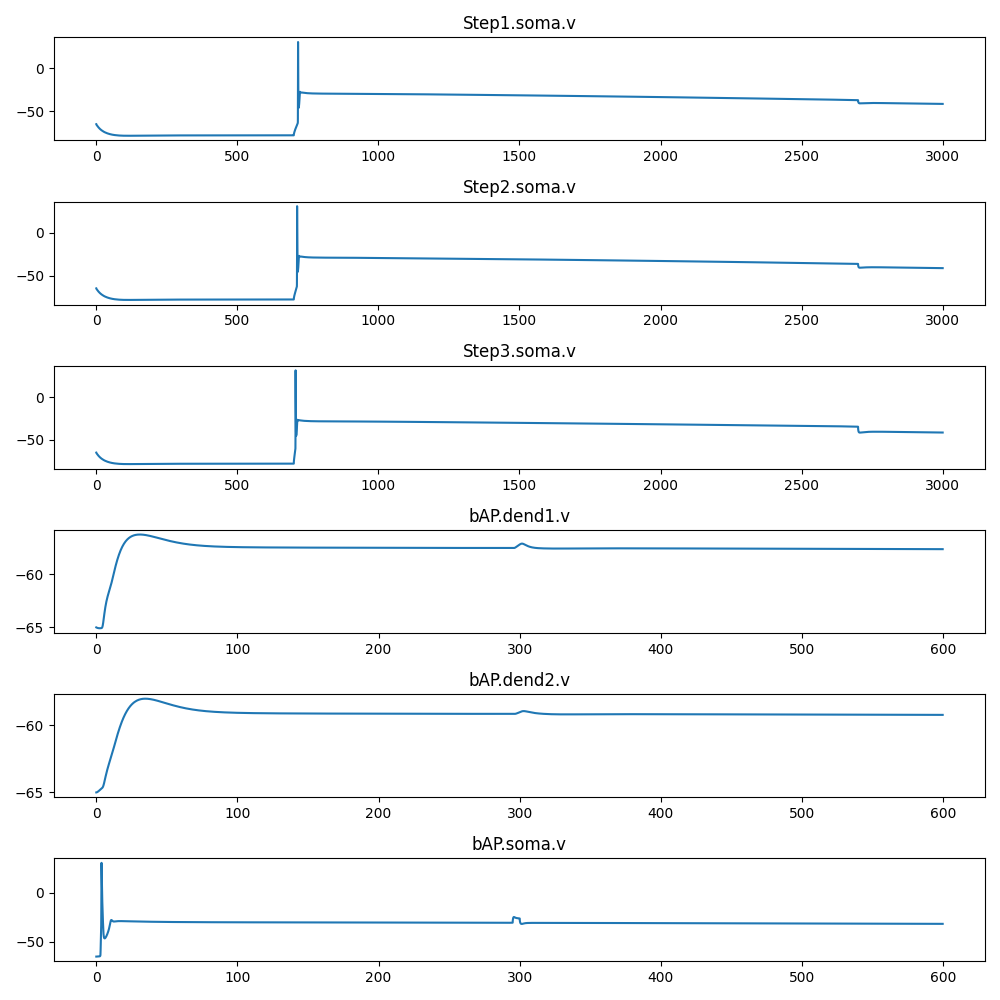

In [21]:
plot_responses(best_responses)